Copyright 2020 The "Value-driven Hindsight Modelling" Authors. All rights reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Hindsight Modelling: Illustrative task of section 3.2.
This implements the task and experiments defined in Section 3.2 and Appendix Section A3 of the "Value-driven Hindsight Modelling paper".

#Task description:
 This is a value estimation problem in a 1-step Markov Reward Process (no actions), namely 
each episode consists of a single transition from initial state $x$ to terminal state $x'$, with a reward $r(x,x')$ on the way. The agent is trained on multiple episodes of each MRP instance. This learning process is repeated independently and averaged for multiple instances of the environment. 
Each instance of the task is parametrized by a square matrix $W$ and a vector $b$ sampled from a unit normal distribution, as well as randomly initialized MLP (see below), which together determine the uncontrolled MDP.
Initial states $x$ are of dimension $D$ and sampled from a multivariate unit normal distribution ($x_i \sim N(0, 1)$ for all state dimension~$i$).
Given $x=\left(\begin{smallmatrix}x_1\\x_2\end{smallmatrix}\right)$, where $x_1$ and $x_2$ are of dimension $D_1$ and $D_2$ ($D=D_1+D_2$),
the next state ${x' = \left(\begin{smallmatrix}x_1'\\x_2'\end{smallmatrix}\right)}$ is determined according to the transition function: $x_1'=\text{MLP}(x) + \epsilon$ and $x_2' = \sigma(W x_2 + b)$ where $\sigma$ is the Heaviside function, and MLP is a randomly sampled Multi-Layer Perceptron. $x_1'$ acts as a distractor here, with additive noise $\epsilon \sim N(0,1)$. The reward obtained is $r(x,x') = \sum_i x^{(i)}_1 \sum_i x'^{(i)}_2 / \sqrt{D}$. The true value in the start state is also $v(x) = r(x,x')$.


In [0]:
#@title Install extra dependencies
!pip install dm-haiku
!pip install dm-tree

In [0]:
#@title Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import functools
from functools import reduce

import haiku as hk
import IPython
import jax
from jax import numpy as jnp
from jax import random
from jax.experimental import optix
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns
import tree

sns.set(rc={"lines.linewidth": 2.0})
sns.set_style("whitegrid")

ipython = IPython.get_ipython()
ipython.magic("%config InlineBackend.figure_format = 'retina'")

In [0]:
#@title Functions to generate dynamics and trajectories

def gen_dynamics(rng_key, x_dims):
  """Generate dynamics (transition+reward functions) for one problem instance. """
  x1_dim, x2_dim = x_dims
  x_dim = x1_dim + x2_dim

  # Sample dynamics parameters to compute x2' from x2
  rng_key, w_rng_key, b_rng_key = random.split(rng_key, 3)
  w_dy = random.normal(w_rng_key, shape=(x2_dim, x2_dim))
  b_dy = random.normal(b_rng_key, shape=(x2_dim,))

  # Sample MLP parameters that controls the x->x1' transition
  rng_key, w_rng_key, b_rng_key = random.split(rng_key, 3)
  w2_dy = random.normal(w_rng_key, shape=(x_dim, x_dim))
  b2_dy = random.normal(b_rng_key, shape=(x_dim,))
  rng_key, w_rng_key, b_rng_key = random.split(rng_key, 3)
  w3_dy = random.normal(w_rng_key, shape=(x_dim, x1_dim))
  b3_dy = random.normal(b_rng_key, shape=(x1_dim,))

  @jax.vmap
  def transition_fn(rng_key, x):
    """Sample x' from x."""
    x2 = x[-x2_dim:]
    x2p = jnp.heaviside(x2.dot(w_dy) + b_dy, 0.0)
    x1p = jax.nn.sigmoid(x.dot(w2_dy) + b2_dy)
    x1p = jax.nn.sigmoid(x1p.dot(w3_dy) + b3_dy)
    x1p += random.normal(rng_key, shape=(x1_dim,))
    xp = jnp.concatenate([x1p, x2p])
    return xp

  @jax.vmap
  def reward_fn(x, xp):
    """Compute reward from x and x'.

    Note: this is also a deterministic function of x by construction.
    """
    x2p = xp[-x2_dim:]
    x1 = x[:x1_dim]
    r = jnp.sum(x2p) * jnp.sum(x1) / jnp.sqrt(x_dim)
    return r

  def data_generator(rng_key, batch_size):
    def body(rng_key):
      rng_key, x_rng_key, xp_rng_key = random.split(rng_key, 3)
      x = random.normal(x_rng_key, shape=(batch_size, x_dim))
      xp = transition_fn(random.split(xp_rng_key, batch_size), x)
      r = reward_fn(x, xp)
      return rng_key, (x, xp, r)
    body = jax.jit(body)

    while True:
      rng_key, data = body(rng_key)
      yield data

  return data_generator

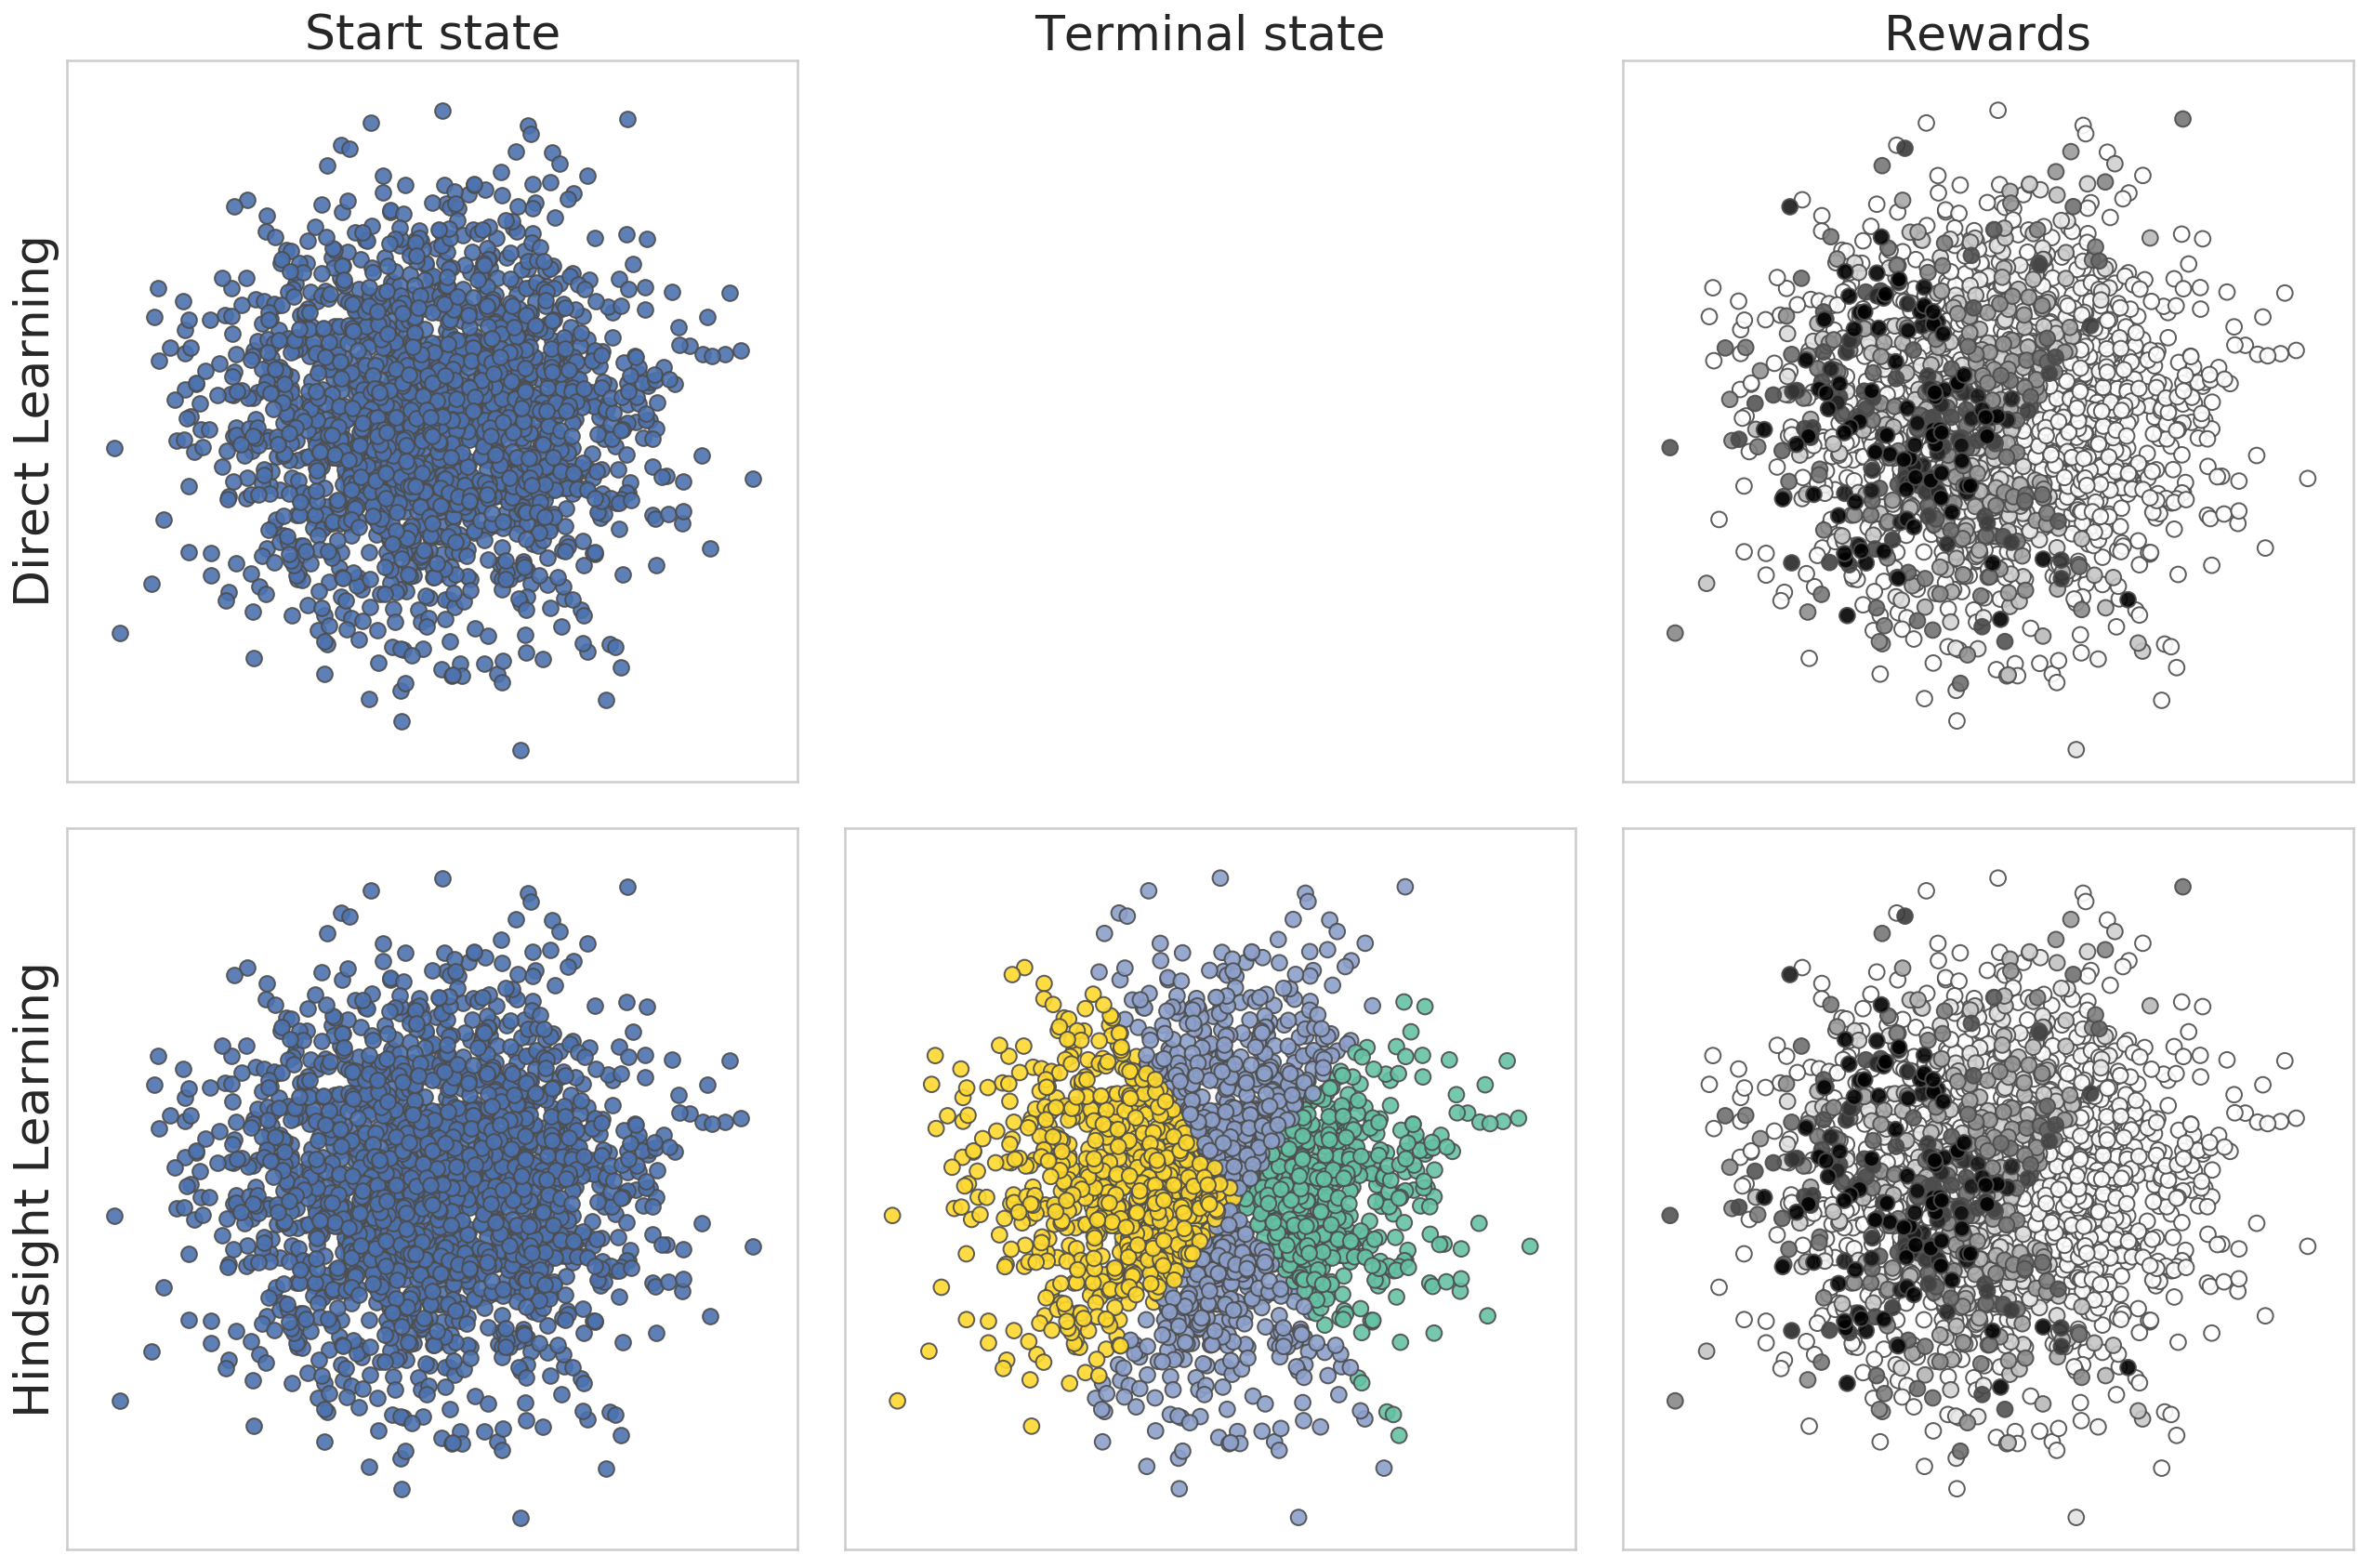

In [0]:
#@title Visualization of example trajectories

FONT_SIZE = 26
LINE_WIDTH = 1.1
MARKER_SIZE = 70
ALPHA = 0.9
GRAY = (0.3, 0.3, 0.3)
SZ = 6
N = 2000
scatter_plot_settings = dict(s=MARKER_SIZE, alpha=ALPHA, edgecolor=GRAY)

x1_dim = 2
x2_dim = 2

env_key, episode_key = random.split(random.PRNGKey(14))
generator_fn = gen_dynamics(env_key, x_dims=(x1_dim, x2_dim))
gen = generator_fn(episode_key, batch_size=N)
(x, xp, r) = next(gen)
ind = jnp.argsort(r)
(x, xp, r) = (jax.device_get(d[ind]) for d in (x, xp, r))

plt.figure(figsize=(3*SZ, 2*SZ))
x2 = x[:, x1_dim:]
x2p = xp[:, x1_dim:]
plt.subplot(2, 3, 1)
plt.scatter(x2[:, 0], x2[:, 1], c='b', **scatter_plot_settings)
plt.title('Start state', fontdict=dict(size=FONT_SIZE))
plt.ylabel('Direct Learning', fontdict=dict(size=FONT_SIZE))

plt.subplot(2, 3, 4)
plt.scatter(x2[:, 0], x2[:, 1], c='b', **scatter_plot_settings)
plt.ylabel('Hindsight Learning', fontdict=dict(size=FONT_SIZE))

plt.subplot(2, 3, 2)
plt.title('Terminal state', fontdict=dict(size=FONT_SIZE))

sums = np.sum(x2p, axis=1)
sums[(sums!=1) * (sums!=0)] = 2
plt.subplot(2, 3, 5)
plt.scatter(x2[:, 0], x2[:, 1], c=cm.Set2(sums/3), **scatter_plot_settings)

# Visualize rewards with colors
plt.subplot(2, 3, 3)
plt.scatter(x2[:, 0], x2[:, 1], c=cm.binary(r/2.0), **scatter_plot_settings)
plt.title('Rewards', fontdict=dict(size=FONT_SIZE))
plt.subplot(2, 3, 6)
plt.scatter(x2[:, 0], x2[:, 1], c=cm.binary(r/2.0), **scatter_plot_settings)

for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.xlim([-3.5, 3.5])
  plt.ylim([-3.5, 3.5])
  plt.grid('off')
  plt.tick_params(
      axis='both', which='both', bottom=False, top=False, left=False,
      right=False, labelbottom=False, labelleft=False)   

plt.subplot(2, 3, 2)
plt.axis('off')
plt.tight_layout(pad=1.4)

In [0]:
#@title Network and loss definitions

class HindsightValueNet(hk.Module):
  """HiMo value estimation architecture.

  This defines the network for the value function and hindsight value functions. It can
  also be used as a model-free baseline with the baseline_mode flag to control for capacity.
  """

  def __init__(self,
               hidden_size=8,
               phi_size=4,
               baseline_mode=False,
               name="HindsightValueNet"):
    """Init.

      Args:
        hidden_size: Dimension of the hidden layers throughout the network.
        phi_size: Dimension of the hindsight bottleneck phi vector, and its approximation phi_hat.
        baseline_mode: boolean, whether to use the network in model-free mode as a baseline.
    """
    super(HindsightValueNet, self).__init__(name=name)
    self._phi_size = phi_size
    self._hidden_size = hidden_size
    self._baseline_mode = baseline_mode

  def __call__(self, inputs):
    """Network definition based on inputs.

      Args:
        inputs: Network inputs, tuple composed of initial observation x and next obs x'.

      Returns:
        The predictions v_pred (only uses x), v_hind_pred (uses both x and x'), and the phi/phi_hat
        vectors.
    """
    x, xp = inputs

    phi_net = hk.nets.MLP(
        output_sizes=[self._hidden_size, self._phi_size], activate_final=False)
    phi = phi_net(xp)

    h_net = hk.nets.MLP(
        output_sizes=[self._hidden_size, self._hidden_size],
        activate_final=True)
    h = h_net(x)

    phi_hat_net = hk.nets.MLP(
        output_sizes=[self._phi_size], activate_final=False)
    phi_hat = phi_hat_net(h)

    v_hind_pred_net = hk.nets.MLP(
        output_sizes=[self._hidden_size, 1])
    v_hind_pred = v_hind_pred_net(jnp.concatenate([h, phi], axis=-1))

    v_pred_net = hk.nets.MLP(
        output_sizes=[self._hidden_size, 1])
    if not self._baseline_mode:
      v_pred_inputs = jnp.concatenate(
          [h, jax.lax.stop_gradient(phi_hat)], axis=-1)
    else:
      v_pred_inputs = jnp.concatenate([h, phi_hat], axis=-1)
    v_pred = v_pred_net(v_pred_inputs)

    return v_pred, v_hind_pred, phi, phi_hat


class ModelValueNet(hk.Module):
  """Model-based value architecture.

  This trains a value network that depends on x and x' (in this case can be interpreted as a
  reward function r(x,x') that depends on that single transition), and a model network to predict x'
  from x. The value is estimated at test time by passing the predicted x' to the value network.
  """
  def __init__(self,
               hidden_size=8,
               name="ModelValueNet"):
    """Init.

    Args:
      hidden_size: Dimension of the hidden layers throughout the network.
    """
    super(ModelValueNet, self).__init__(name=name)
    self._hidden_size = hidden_size

  def __call__(self, inputs):
    """Network definition based on inputs.

    Args:
      inputs: Network inputs, tuple composed of initial observation x and next obs x'.

    Returns:
      The predictions v_pred (uses x and x'), v_pred_test (uses x and x' prediction), and the x'
      prediction (xp_pred).
    """
    x, xp = inputs

    v_pred_net = hk.nets.MLP(
        output_sizes=[self._hidden_size, self._hidden_size,
                      self._hidden_size, 1])
    v_pred = v_pred_net(jnp.concatenate([x, xp], axis=-1))

    xp_pred_net = hk.nets.MLP(
        output_sizes=[self._hidden_size, self._hidden_size, x.shape[1]])
    xp_pred = xp_pred_net(x)
    v_pred_test = v_pred_net(jnp.concatenate([x, xp_pred], axis=-1))

    return v_pred, v_pred_test, xp_pred


def vnet_loss(hidden_size, phi_size):
  """Computes the loss for the model-free value network baseline."""
  def loss_fn(inputs):
    x, xp, r = inputs

    hind_v_net = HindsightValueNet(
        hidden_size=hidden_size, phi_size=phi_size, baseline_mode=True)
    v_pred, _, _, _ = hind_v_net([x, xp])

    loss = jnp.mean((v_pred - r)**2)
    return loss, (loss,)
  return hk.transform(loss_fn)


def vnet_himo_loss(hidden_size, phi_size, model_loss_weight=3.0):
  """Computes the loss for the hindsight modelling network."""
  def loss_fn(inputs):
    x, xp, r = inputs

    hind_v_net = HindsightValueNet(hidden_size=hidden_size, phi_size=phi_size)
    v_pred, v_hind_pred, phi, phi_hat = hind_v_net([x, xp])

    v_loss = jnp.mean((v_pred - r)**2)
    v_hind_loss = jnp.mean((v_hind_pred - r)**2)
    model_loss = jnp.mean((phi_hat - jax.lax.stop_gradient(phi))**2)

    loss = v_loss + v_hind_loss + model_loss_weight * model_loss
    return loss, (v_loss, v_hind_loss, model_loss)

  return hk.transform(loss_fn)


def vnet_model_loss(hidden_size, model_loss_weight=3.0):
  """Computes the loss for the model-based baseline."""
  def loss_fn(inputs):
    x, xp, r = inputs
    model_v_net = ModelValueNet(hidden_size=hidden_size)

    v_pred, v_pred_test, xp_pred = model_v_net([x, xp])

    train_v_loss = jnp.mean((v_pred - r)**2)
    test_v_loss = jnp.mean((v_pred_test - r)**2)
    model_loss = jnp.mean((xp_pred - jax.lax.stop_gradient(xp))**2)

    loss = train_v_loss + model_loss_weight * model_loss

    return loss, (test_v_loss, train_v_loss, model_loss)

  return hk.transform(loss_fn)

In [0]:
#@title Training loops
def get_update_fn(loss_fn, opt):
  """Builds and returns a pmapped update function that runs on all devices.

  Args:
   loss_fn: the loss function to be optimized.
   opt: the optix optimizer to be used for loss minimization.

  Returns:
    pmapped update function.
  """

  def update_fn(params, opt_state, *inputs):
    rng = None
    grads, loss = jax.grad(loss_fn, has_aux=True)(params, rng, *inputs)
    grads = jax.lax.pmean(grads, axis_name='i')
    updates, opt_state = opt.update(grads, opt_state)
    params = optix.apply_updates(params, updates)
    return params, opt_state, loss

  update_fn = jax.pmap(update_fn, axis_name='i')
  return update_fn


def train(rng_key,
          loss_fn,
          data_generator,
          batch_size=16,
          learning_rate=1e-3,
          num_training_iterations=5000,
          report_interval=100,
          mv_avg_decay=0.99,
          logging_prefix=''):
  """Traininig script."""

  num_devices = jax.local_device_count()

  opt = optix.adam(learning_rate=learning_rate, eps=1e-3)
  update_fn = get_update_fn(loss_fn.apply, opt)
  reshape = lambda x: jnp.reshape(
      x, [num_devices, batch_size//num_devices, -1])
  gen = map(lambda x: tree.map_structure(reshape, x),
            data_generator(rng_key, batch_size=batch_size))

  # NOTE: use the same key on all devices to initialise parameters to the same
  # value on all devices.
  rng_key, _ = random.split(rng_key)
  params = jax.pmap(loss_fn.init)(
      jnp.stack([rng_key] * num_devices), next(gen))
  opt_state = jax.pmap(opt.init)(params)

  for train_iteration in range(num_training_iterations):
    params, opt_state, aux = update_fn(params, opt_state, next(gen))
    # The loss returned by `update_fn` is an array of shape [n_devices].
    # Take the mean to get a single value.
    aux = tree.map_structure(jnp.mean, aux)
    if train_iteration == 0:
      aux_smoothed = aux
      aux_data = tree.map_structure(lambda x: [], aux) + ([],)
    else:
      mv_avg = lambda x, y: x * mv_avg_decay + y * (1 - mv_avg_decay)
      aux_smoothed = tree.map_structure(mv_avg, aux_smoothed, aux)

    if (train_iteration + 1) % report_interval == 0:
      message = logging_prefix + ' - progress: {0:3.0f}%'.format(
        train_iteration/(num_training_iterations-1)*100)
      print(message, end='\r')
      to_add = aux_smoothed + (train_iteration,)
      tree.map_structure_up_to(
          to_add, lambda x, y: x.append(y), aux_data, to_add)
  return aux_data

Running on 1 devices of type cpu:0
Num runs: 10 -- Batch size: 64
Training vnet...
Training himo...
Training model-based vnet...
Done!


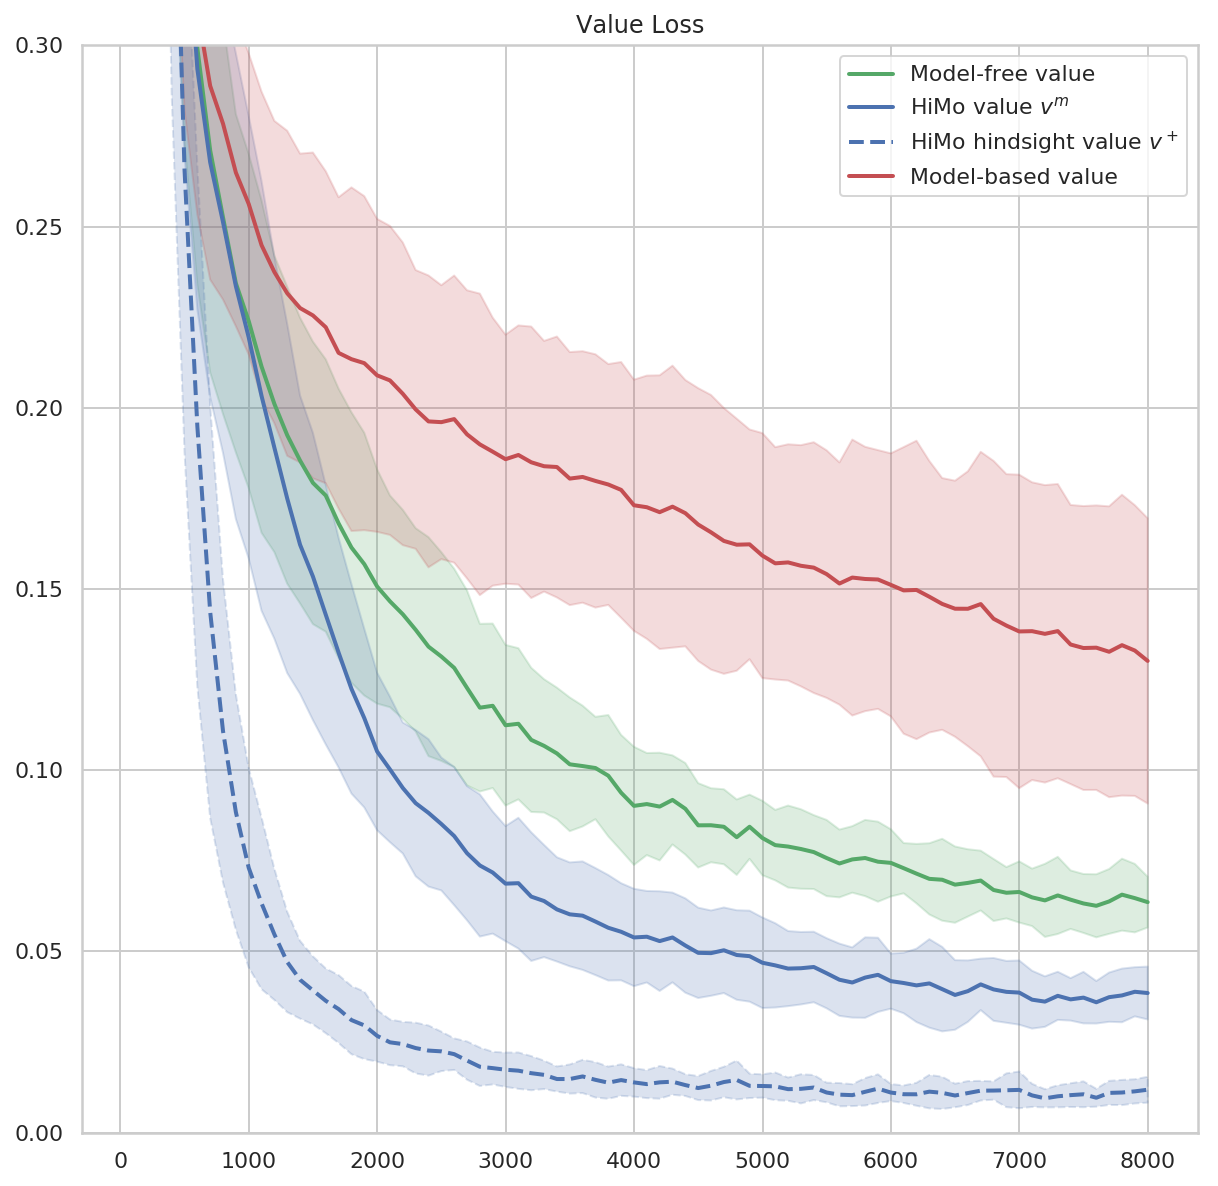

In [0]:
#@title Training example

# Shared hyper-parameters
hidden_size = 16
phi_size = 3
x1_dim, x2_dim = 28, 4
batch_size = 8 * 8
learning_rate = 4e-3
num_training_iterations = int(8e3)
rng_key = random.PRNGKey(14)
num_runs = 10


def execute(rng_keys, loss):
  stats = []
  for run_index, rng_key in enumerate(rng_keys):
    logging_prefix = 'Executing run {}/{}'.format(run_index+1, len(rng_keys))
    generator = gen_dynamics(rng_key, x_dims=(x1_dim, x2_dim))
    stats.append(train(
        rng_key,
        loss,
        data_generator=generator,
        batch_size=batch_size,
        learning_rate=learning_rate,
        num_training_iterations=num_training_iterations,
        report_interval=100,
        mv_avg_decay=0.99,
        logging_prefix=logging_prefix))
  return stats


def process(stats, index, *args, **kwargs):
  it = stats[0][-1]
  stats = [stat[index] for stat in stats]
  stats = np.stack(stats)
  mean = np.mean(stats, axis=0)
  std = np.std(stats, axis=0)
  plt.plot(it, mean, **kwargs)
  plt.fill_between(it, mean-std, mean+std, alpha=0.2, *args, **kwargs)


print('Running on {} devices of type {}'.format(
    jax.local_device_count(), jax.devices()[0]))
print('Num runs: {} -- Batch size: {}'.format(num_runs, batch_size))

rng_keys = random.split(rng_key, num_runs)

print('Training vnet...')
vnet_loss_fn = vnet_loss(hidden_size=hidden_size, phi_size=phi_size)
vnet_stats = execute(rng_keys, vnet_loss_fn)

print('Training himo...')
himo_loss_fn = vnet_himo_loss(hidden_size=hidden_size, phi_size=phi_size)
himo_stats = execute(rng_keys, himo_loss_fn)

print('Training model-based vnet...')
vnet_model_loss_fn = vnet_model_loss(hidden_size=hidden_size)
vnet_model_stats = execute(rng_keys, vnet_model_loss_fn)

print('Done!')


plt.figure(figsize=(10, 10))
process(vnet_stats, 0,  color='g')
process(himo_stats, 0, color='b')
process(himo_stats, 1,  color='b', linestyle='--')
process(vnet_model_stats, 0,  color='r')
plt.ylim([0, .3])
plt.legend([
    'Model-free value',
    'HiMo value $v^m$',
    'HiMo hindsight value $v^+$',
    'Model-based value',
])
plt.title('Value Loss');